In [1]:
# pip install nilearn nibabel
import numpy as np, nibabel as nib
from nilearn import datasets, image

# -----------------------------
# 0) Config: where to resample
# -----------------------------
target_img_path = None  # e.g., 'sub-01_T1w.nii.gz' or 'sub-01_task-evs_bold.nii.gz'
outdir = '.'            # where to save masks

In [12]:
# Harvard–Oxford (maxprob, 2mm) for broad cortical + subcortical structures
ho_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split=True)
ho_subc = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm', symmetric_split=True)
ho_cort_img, ho_subc_img = ho_cort.maps, ho_subc.maps
ho_cort_labels = [l.lower() for l in ho_cort.labels]
ho_subc_labels = [l.lower() for l in ho_subc.labels]
print("Cortical Labels:  ", ho_cort_labels)
print("Sub-cortical Labels:   ", ho_subc_labels)

# Jülich (maxprob, 2mm) for motor/SMA/premotor/IPS/STN/cerebellum
jul = datasets.fetch_atlas_juelich('maxprob-thr25-2mm')
jul_img = jul.maps
jul_labels = [l.lower() for l in jul.labels]
print("Jülich Labels:    ", jul_labels)

[fetch_atlas_harvard_oxford] Dataset found in /home/zkavian/nilearn_data/fsl
[fetch_atlas_harvard_oxford] Dataset found in /home/zkavian/nilearn_data/fsl
Cortical Labels:   ['background', 'left frontal pole', 'right frontal pole', 'left insular cortex', 'right insular cortex', 'left superior frontal gyrus', 'right superior frontal gyrus', 'left middle frontal gyrus', 'right middle frontal gyrus', 'left inferior frontal gyrus, pars triangularis', 'right inferior frontal gyrus, pars triangularis', 'left inferior frontal gyrus, pars opercularis', 'right inferior frontal gyrus, pars opercularis', 'left precentral gyrus', 'right precentral gyrus', 'left temporal pole', 'right temporal pole', 'left superior temporal gyrus, anterior division', 'right superior temporal gyrus, anterior division', 'left superior temporal gyrus, posterior division', 'right superior temporal gyrus, posterior division', 'left middle temporal gyrus, anterior division', 'right middle temporal gyrus, anterior division

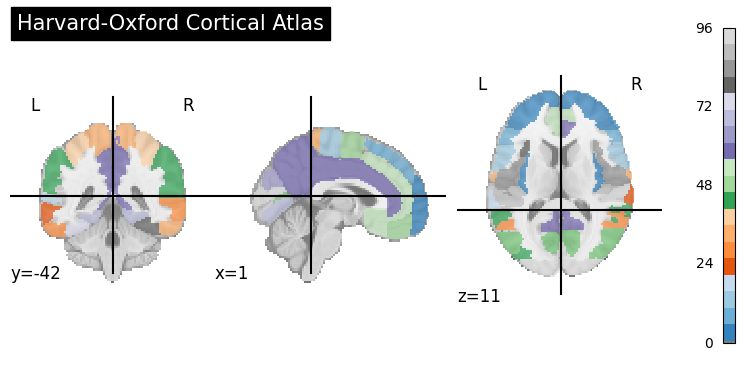

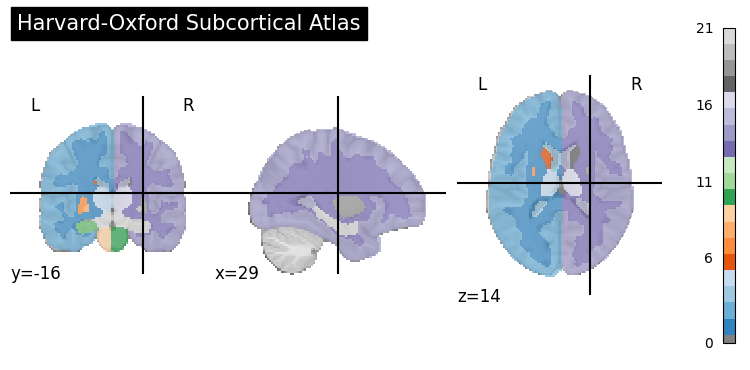

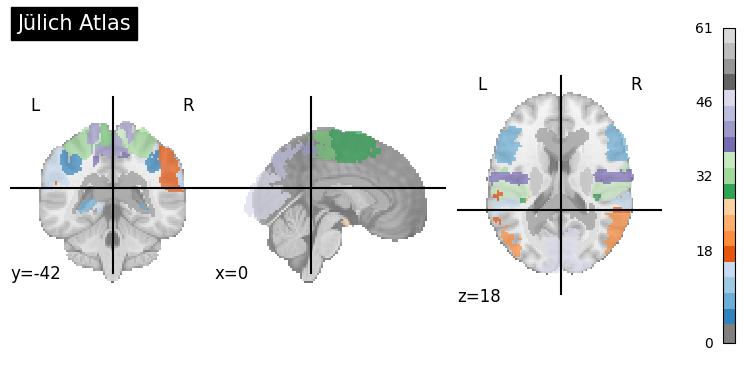

In [13]:
from nilearn import plotting

# Plot cortical atlas (each region gets a different color)
plotting.plot_roi(ho_cort_img, title="Harvard-Oxford Cortical Atlas", display_mode='ortho', cmap='tab20c')  

# Plot subcortical atlas
plotting.plot_roi(ho_subc_img, title="Harvard-Oxford Subcortical Atlas", display_mode='ortho', cmap='tab20c')

plotting.plot_roi(jul_img, title="Jülich Atlas", display_mode='ortho', cmap='tab20c')
plotting.show()

In [16]:
atlas_img = ho_cort_img
view = plotting.view_img(atlas_img, cmap='tab20c', threshold=0)  
view.save_as_html('cortical atlas.html')

atalas_img = ho_subc_img
view = plotting.view_img(atlas_img, cmap='tab20c', threshold=0)
view.save_as_html('subcortical atlas.html')

atlas_img = jul_img
view = plotting.view_img(atlas_img, cmap='tab20c', threshold=0)
view.save_as_html('juelich atlas.html')

In [17]:
def idx_contains(labels, terms):
    terms = [t.lower() for t in terms]
    return [i for i, name in enumerate(labels) if any(t in name for t in terms)]

def mask_from_indices(atlas_img, indices):
    data = atlas_img.get_fdata()
    # For max-probability atlases, voxel values equal integer label indices.
    m = np.isin(data, indices).astype(np.uint8)
    return nib.Nifti1Image(m, atlas_img.affine, atlas_img.header)

def or_masks(*imgs):
    data = np.zeros(imgs[0].shape, dtype=np.uint8)
    for im in imgs:
        if im is not None:
            data |= (im.get_fdata() > 0).astype(np.uint8)
    return nib.Nifti1Image(data, imgs[0].affine, imgs[0].header)

def resample_like(img, target):
    return image.resample_to_img(img, target, interpolation='nearest')

In [ ]:
R_PRIMARY_MOTOR = ['area 4a', 'area 4p']                   # M1
R_PRIMARY_SOMA  = ['area 3a', 'area 3b', 'area 1', 'area 2']# S1
R_SMA           = ['area 6mp', 'area 6ma']                  # SMA proper / preSMA
R_PMd           = ['area 6d']                               # dorsal premotor
R_PMv           = ['area 6v']                               # ventral premotor

# Posterior parietal for visuomotor control: IPS + SPL/IPL (use Jülich hIP + HO SPL/IPL)
R_PPC_JUL       = ['hip1', 'hip2', 'hip3']                  # Jülich human IPS
R_PPC_HO        = ['superior parietal', 'inferior parietal', 'supramarginal', 'angular']

# Cerebellum (Jülich contains lobules; collect anything with 'cerebellum')
R_CEREB         = ['cerebellum']

# Subcortical (HO for robust anatomical nuclei; plus Jülich STN)
R_VS            = ['accumbens']                             # ventral striatum
R_PUTAMEN       = ['putamen']
R_PALLIDUM      = ['pallidum', 'globus pallidus']           # HO label uses "pallidum"
R_STN_JUL       = ['subthalamic']
R_THALAMUS      = ['thalamus']
R_AMYGDALA      = ['amygdala']
R_HIPPO         = ['hippocampus']

# Insula / cingulate / vmPFC-OFC (HO cortical)
R_ANT_INSULA    = ['insular cortex']                        # HO doesn’t split anterior; grabs full insula
R_ACC           = ['cingulate gyrus, anterior']             # mid/dorsal ACC approx.
R_PCC_PREC      = ['cingulate gyrus, posterior', 'precuneus']
R_vmPFC_OFC     = ['frontal medial cortex', 'frontal orbital cortex', 'subcallosal cortex']

# -----------------------------
# 3) Build each region mask
# -----------------------------
def ho_cort_mask(terms):
    idx = idx_contains(ho_cort_labels, terms)
    return mask_from_indices(ho_cort_img, idx) if idx else None

def ho_subc_mask(terms):
    idx = idx_contains(ho_subc_labels, terms)
    return mask_from_indices(ho_subc_img, idx) if idx else None

def jul_mask(terms):
    idx = idx_contains(jul_labels, terms)
    return mask_from_indices(jul_img, idx) if idx else None

masks = {}

# Primary motor cortex (M1)
masks['primary_motor_cortex'] = jul_mask(R_PRIMARY_MOTOR)

# Primary somatosensory cortex (S1)
masks['primary_somatosensory_cortex'] = jul_mask(R_PRIMARY_SOMA)

# Supplementary motor area (SMA / preSMA)
masks['sma'] = jul_mask(R_SMA)

# Dorsal & ventral premotor cortex
masks['premotor_dorsal']  = jul_mask(R_PMd)
masks['premotor_ventral'] = jul_mask(R_PMv)

# Posterior parietal cortex for visuomotor control (Jülich IPS + HO SPL/IPL complex)
masks['posterior_parietal_visuomotor'] = or_masks(
    jul_mask(R_PPC_JUL),
    ho_cort_mask(R_PPC_HO)
)

# Cerebellum (all lobules in Jülich)
masks['cerebellum'] = jul_mask(R_CEREB)

# Ventral striatum (accumbens)
masks['ventral_striatum'] = ho_subc_mask(R_VS)

# Anterior insula (approx by full insula in HO)
masks['anterior_insula'] = ho_cort_mask(R_ANT_INSULA)

# Thalamus
masks['thalamus'] = ho_subc_mask(R_THALAMUS)

# ACC (mid/dorsal approx) & PCC/Precuneus
masks['anterior_cingulate'] = ho_cort_mask(R_ACC)
masks['posterior_cingulate_precuneus'] = ho_cort_mask(R_PCC_PREC)

# vmPFC / OFC
masks['vmPFC_OFC'] = ho_cort_mask(R_vmPFC_OFC)

# Putamen, Pallidum, STN, Amygdala, Hippocampus
masks['putamen'] = ho_subc_mask(R_PUTAMEN)
masks['globus_pallidus'] = ho_subc_mask(R_PALLIDUM)
masks['subthalamic_nucleus'] = jul_mask(R_STN_JUL)
masks['amygdala'] = ho_subc_mask(R_AMYGDALA)
masks['hippocampus'] = ho_subc_mask(R_HIPPO)

# -----------------------------
# 4) Resample (optional) and save
# -----------------------------
target_img = nib.load(target_img_path) if target_img_path else None
for name, m in list(masks.items()):
    if m is None:
        print(f"[WARN] No labels matched for: {name}")
        continue
    if target_img is not None:
        m = resample_like(m, target_img)
        masks[name] = m
    nib.save(m, f"{outdir}/mask_{name}.nii.gz")

# Combined union mask
valid_masks = [m for m in masks.values() if m is not None]
union_mask = or_masks(*valid_masks) if valid_masks else None
if union_mask is not None:
    if target_img is not None:
        union_mask = resample_like(union_mask, target_img)
    nib.save(union_mask, f"{outdir}/mask_ALL_UNION.nii.gz")

print("Done. Saved individual masks and mask_ALL_UNION.nii.gz")
